# Making Predictions - Rentals
This notebook explores different models that can be used to predict *rentals* for the month of **April** on the combined 3 month dataset, filtered for *200 selected stations* that are closer to each other. 
- Training data: from 31 Dec 2023 + Jan to March 31 2024
- Test data: 1 April 2023 to 30 April 2024

## Importing the dataset

In [1]:
# Import
import pandas as pd
selected_rentals = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 5 (TU Dresden)\Research Task - Spatial Modelling\Code\rentals_near200_st.csv")
selected_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170800 entries, 0 to 170799
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   name         170800 non-null  object 
 1   lat          170800 non-null  float64
 2   lng          170800 non-null  float64
 3   datetime     170800 non-null  object 
 4   #_rentals    170800 non-null  int64  
 5   year         170800 non-null  int64  
 6   month        170800 non-null  int64  
 7   day          170800 non-null  int64  
 8   hour         170800 non-null  int64  
 9   ID           170800 non-null  int64  
 10  coordinates  170800 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 14.3+ MB


## No Location Information
Firstly, no spatial/location information is used for the purpose of predictions. Only *temporal information* is fed into the models.

## Characteristics of Time-Series Forecasting
Time-series forecasting involves predicting future values based on past observed data, taking into account the temporal order and dependencies. 
- The rentals dataset has an inherent temporal structure (rentals depend on time of day). 
- We're trying to predict future values (April) based on historical observations (January to March). April's rentals are likely to depend on rentals from previous months.

In [2]:
# Only preserving temporal information
selected_rentals = selected_rentals[["name", "#_rentals", "year", "month", "day", "hour", "ID"]]
selected_rentals.head()

,name,#_rentals,year,month,day,hour,ID
0,1 Ave & E 110 St,0,2023,12,31,8,0
1,1 Ave & E 110 St,1,2024,3,28,10,0
2,1 Ave & E 110 St,1,2024,3,28,12,0
3,1 Ave & E 110 St,1,2024,3,28,14,0
4,1 Ave & E 110 St,3,2024,3,28,16,0


## Compartmentalizing the Data
For making predictions, we only want that a selected station uses its own historical data while excluding the information from other stations. Hence, the training and test data must be exclusive to a particular station. 

## Which Methods to use?
For applied machine learning using structured data, the most tried and tested methods in tradtional machine learning are either ensembles of decision trees *such as random forests* or gradient boosting machines *such as XGBoost* (Howard & Gugger, 'Tabular Modelling Deep Dive'). Since this is a time-series problem, *linear models* might also provide good performance if the assumption of linearity holds good.

### Simple Linear Model (No temporal dependence)
To use this model, it would be good to first check if the assumption of **linearity** with *hour* actually holds for a given station. The *hour* feature is considered because we are very interested to know *how rentals vary every two hours* and can this relationship be represented in a linear fashion or not.

In [3]:
# IDs of first 10 stations available
selected_rentals["ID"].unique()[:10]

array([ 0,  9, 54, 55, 62, 63, 66, 67, 72, 74], dtype=int64)

#### Variation by hour
For a given station, how are rentals varying with time in a day?

In [4]:
# station ID '9', 20 Mar 2024
sample_1 = selected_rentals[(selected_rentals["ID"] == 9) & (selected_rentals["month"] == 3) & (selected_rentals["day"] == 20)]
print(sample_1)

# station ID '0', 7 Feb 2024
sample_2 = selected_rentals[(selected_rentals["ID"] == 0) & (selected_rentals["month"] == 2) & (selected_rentals["day"] == 7)]
print(sample_2)

# station ID '74', 18 Jan 2024
sample_3 = selected_rentals[(selected_rentals["ID"] == 74) & (selected_rentals["month"] == 1) & (selected_rentals["day"] == 18)]
print(sample_3)

                 name  #_rentals  year  month  day  hour  ID
989   1 Ave & E 94 St          3  2024      3   20    14   9
990   1 Ave & E 94 St          0  2024      3   20    12   9
991   1 Ave & E 94 St          3  2024      3   20    10   9
992   1 Ave & E 94 St          8  2024      3   20     8   9
1175  1 Ave & E 94 St          1  2024      3   20    16   9
1280  1 Ave & E 94 St          2  2024      3   20    18   9
1281  1 Ave & E 94 St          1  2024      3   20    20   9
                 name  #_rentals  year  month  day  hour  ID
514  1 Ave & E 110 St          1  2024      2    7    20   0
515  1 Ave & E 110 St          1  2024      2    7    18   0
516  1 Ave & E 110 St          3  2024      2    7    16   0
517  1 Ave & E 110 St          2  2024      2    7    14   0
518  1 Ave & E 110 St          1  2024      2    7    12   0
519  1 Ave & E 110 St          3  2024      2    7    10   0
520  1 Ave & E 110 St          7  2024      2    7     8   0
                      na

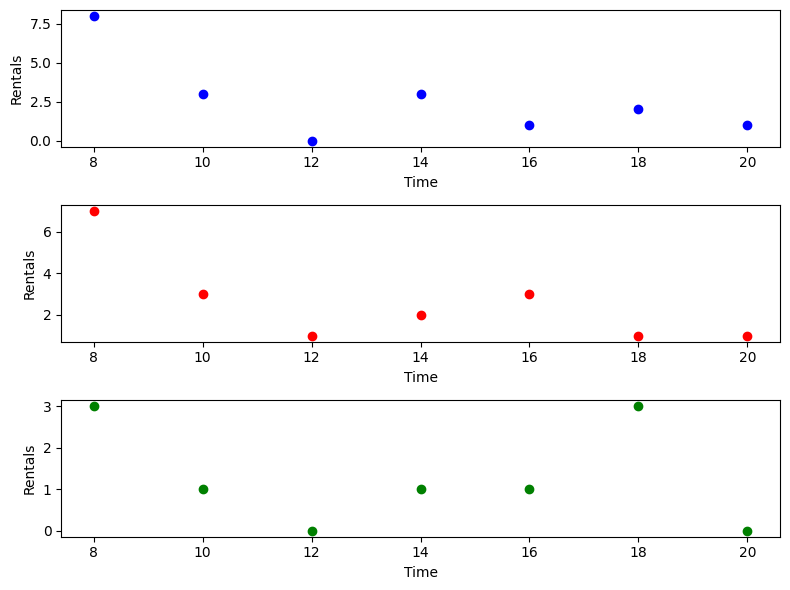

In [5]:
# variation of rentals (in a day) by time 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)  
plt.scatter(sample_1["hour"], sample_1["#_rentals"],color='b', label='sample 1')# sample 1
plt.xlabel("Time")
plt.ylabel("Rentals")

plt.subplot(3, 1, 2) 
plt.scatter(sample_2["hour"], sample_2["#_rentals"],color='r', label='sample 2') # sample 2
plt.xlabel("Time")
plt.ylabel("Rentals")

plt.subplot(3, 1, 3) 
plt.scatter(sample_3["hour"], sample_3["#_rentals"],color='g', label='sample 3') # sample 3
plt.xlabel("Time")
plt.ylabel("Rentals")

plt.tight_layout()
plt.show()

#### Variation by days
For a given station, how are rentals varying by day for a given time window?

In [6]:
# variation of rentals for first week of March (time = 14:00 hr)
# station ID '9', 14:00 hr
sample_4 = selected_rentals[(selected_rentals["ID"] == 9) & (selected_rentals["month"] == 3) & (selected_rentals["hour"] == 14) & (selected_rentals["month"] == 3) & (selected_rentals["day"] <= 7)]
print(sample_4)

# station ID '0', 14:00 hr
sample_5 = selected_rentals[(selected_rentals["ID"] == 0) & (selected_rentals["month"] == 3) & (selected_rentals["hour"] == 14) & (selected_rentals["day"] <= 7)]
print(sample_5)

# station ID '74', 14:00 hr
sample_6 = selected_rentals[(selected_rentals["ID"] == 74) & (selected_rentals["month"] == 3) & (selected_rentals["hour"] == 14) & (selected_rentals["day"] <= 7)]
print(sample_6)

                 name  #_rentals  year  month  day  hour  ID
1505  1 Ave & E 94 St          0  2024      3    5    14   9
1506  1 Ave & E 94 St          0  2024      3    2    14   9
1514  1 Ave & E 94 St          2  2024      3    1    14   9
1524  1 Ave & E 94 St          1  2024      3    7    14   9
1531  1 Ave & E 94 St          0  2024      3    6    14   9
1586  1 Ave & E 94 St          0  2024      3    4    14   9
1593  1 Ave & E 94 St          4  2024      3    3    14   9
                 name  #_rentals  year  month  day  hour  ID
110  1 Ave & E 110 St          1  2024      3    7    14   0
134  1 Ave & E 110 St          4  2024      3    3    14   0
135  1 Ave & E 110 St          0  2024      3    2    14   0
136  1 Ave & E 110 St          0  2024      3    6    14   0
698  1 Ave & E 110 St          3  2024      3    5    14   0
709  1 Ave & E 110 St          0  2024      3    1    14   0
745  1 Ave & E 110 St          2  2024      3    4    14   0
                      na

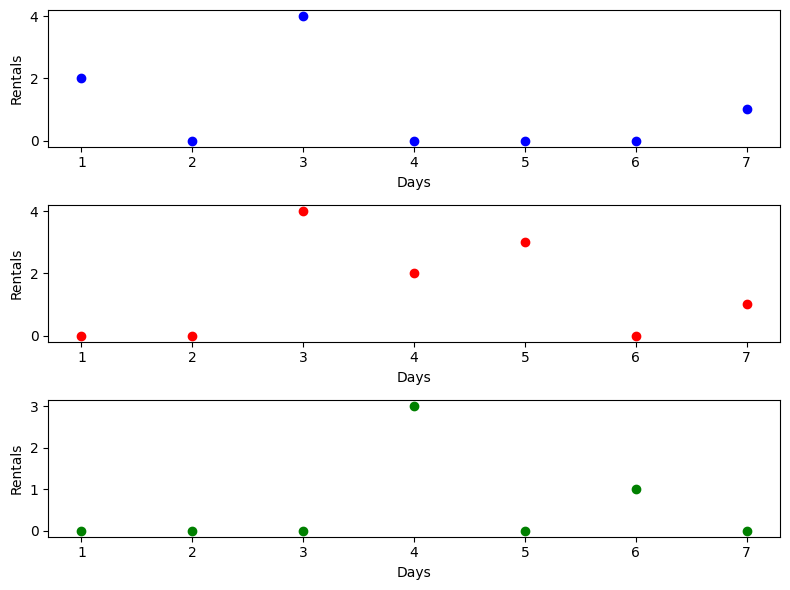

In [7]:
# variation of rentals (for a fixed time) by days 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)  
plt.scatter(sample_4["day"], sample_4["#_rentals"],color='b', label='sample 4')# sample 4
plt.xlabel("Days")
plt.ylabel("Rentals")

plt.subplot(3, 1, 2) 
plt.scatter(sample_5["day"], sample_5["#_rentals"],color='r', label='sample 5') # sample 5
plt.xlabel("Days")
plt.ylabel("Rentals")

plt.subplot(3, 1, 3) 
plt.scatter(sample_6["day"], sample_6["#_rentals"],color='g', label='sample 6') # sample 6
plt.xlabel("Days")
plt.ylabel("Rentals")

plt.tight_layout()
plt.show()

The relationship does not look very linear if **time variables** are modelled without any feature transformations or temporal adaptations.

#### Checking model performance
Creating a simple linear regression learner to see prediction performance on the test data, <u>for a selected station</u>. No feature engineering is done, and the time variables are directly entered into the model as it is.

In [8]:
# Chosen station ID = 0

# training data: target
y_train_0 = selected_rentals.loc[(selected_rentals["ID"] == 0) & ~(selected_rentals["month"] == 4), "#_rentals"]

# test data: target
y_test_0 = selected_rentals.loc[(selected_rentals["year"] == 2024) & (selected_rentals["month"] == 4) & (selected_rentals["ID"] == 0), "#_rentals"]

# Is there any common index value between y_train and y_test - No
y_train_0.index.intersection(y_test_0.index)

Index([], dtype='int64')

In [9]:
# training data: feature
X_train_0 = selected_rentals.loc[(selected_rentals["ID"] == 0) & ~(selected_rentals["month"] == 4), ["year", "month", "day", "hour"]]

# test data: feature
X_test_0 = selected_rentals.loc[(selected_rentals["ID"] == 0) & (selected_rentals["month"] == 4), ["year", "month", "day", "hour"]]

# Is there any common index value between X_train and X_test - No
X_train_0.index.intersection(X_test_0.index)

Index([], dtype='int64')

In [10]:
# Running the model
from sklearn.linear_model import LinearRegression 
lr = LinearRegression().fit(X_train_0, y_train_0)

# training performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_train_pred_0 = lr.predict(X_train_0)
print(mean_squared_error(y_train_0, y_train_pred_0),r2_score(y_train_0, y_train_pred_0))

2.8325257247180624 0.1059030631292961


In [11]:
# performance on test set
y_test_pred_0 = lr.predict(X_test_0)
print(mean_squared_error(y_test_0, y_test_pred_0), r2_score(y_test_0, y_test_pred_0))

4.403994655817022 -0.01896718444043133


In [12]:
# checking performance for a different station
# Chosen station ID = 9

# training data: target
y_train_9 = selected_rentals.loc[(selected_rentals["ID"] == 9) & ~(selected_rentals["month"] == 4), "#_rentals"]
# test data: target
y_test_9 = selected_rentals.loc[(selected_rentals["year"] == 2024) & (selected_rentals["month"] == 4) & (selected_rentals["ID"] == 9), "#_rentals"]
# training data: feature
X_train_9 = selected_rentals.loc[(selected_rentals["ID"] == 9) & ~(selected_rentals["month"] == 4), ["year", "month", "day", "hour"]]
# test data: feature
X_test_9 = selected_rentals.loc[(selected_rentals["ID"] == 9) & (selected_rentals["month"] == 4), ["year", "month", "day", "hour"]]

# training performance
lr_9 = LinearRegression().fit(X_train_9, y_train_9)
y_train_pred_9 = lr_9.predict(X_train_9)
print(mean_squared_error(y_train_9, y_train_pred_9),r2_score(y_train_9, y_train_pred_9))

2.4694350065511257 0.16347484995431072


In [13]:
# performance on test set
y_test_pred_9 = lr_9.predict(X_test_9)
print(mean_squared_error(y_test_9, y_test_pred_9), r2_score(y_test_9, y_test_pred_9))

4.49090365814872 0.08613645820170834


**Conclusion**: The performance is <u>extremely poor</u> using simple linear regression. A negative value of **r2** score means that using the mean value of *rentals* is a much better predictor of rentals compared to using simple linear regression.

### Simple Decision Trees 
#### Default Hyperparameters
Decision Trees are not designed to handle temporal dependencies directly, as they treat each observation as independent of others. In other words, they are not the most suitable for capturing temporal patterns in the data. However, they might still provide decent performance because of their ability to capture <u>non-linear relationships</u> in the data. <br><br>
<u>Note</u>: decision trees *learn* from the training data, however their ability to generalise can be very limited. This is because the month of April lies outside the scope of the timeline on which training data is made. Hence, the data points lying in the test data will not fit any **region** created by the decision tree.

In [14]:
# evaluating training performance for station ID '0' 
from sklearn.tree import DecisionTreeRegressor
tree_0 = DecisionTreeRegressor().fit(X_train_0, y_train_0)
y_train_pred_0_tree = tree_0.predict(X_train_0)
print(mean_squared_error(y_train_0, y_train_pred_0_tree),r2_score(y_train_0, y_train_pred_0_tree))

0.0 1.0


In [15]:
# evaluating testing performance
y_test_pred_0_tree = tree_0.predict(X_test_0)
print(mean_squared_error(y_test_0, y_test_pred_0_tree), r2_score(y_test_0, y_test_pred_0_tree))

7.609523809523809 -0.7606413397621208


This is clearly a case of <u>overfitting!</u> This is a **common downside** of using a single decision tree (Müller & Guido, 'Introduction to Machine Learning with Python'). Therefore, ensembles of decision trees are preferred to avoid this problem in an applied setting.

#### Pruning - *custom hyperparameters*
Pruning (pre-pruning) the tree might help in avoiding the overfitting. For this, *hyperparameters* are needed to be adjusted properly. The hyperparameters that are being considered to prevent overfitting are:
- max_depth 
- max_leaf_nodes
- min_samples_leaf

In [16]:
# controlling for max depth

# training performance
tree_0_with_depth = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train_0, y_train_0)
y_train_pred_0_tree_with_depth = tree_0_with_depth.predict(X_train_0)
print(mean_squared_error(y_train_0, y_train_pred_0_tree_with_depth),r2_score(y_train_0, y_train_pred_0_tree_with_depth))

# test performance
y_test_pred_0_tree_with_depth = tree_0_with_depth.predict(X_test_0)
print(mean_squared_error(y_test_0, y_test_pred_0_tree_with_depth), r2_score(y_test_0, y_test_pred_0_tree_with_depth))

2.1686770559401767 0.315449284058704
4.56539608394746 -0.05631118043495564


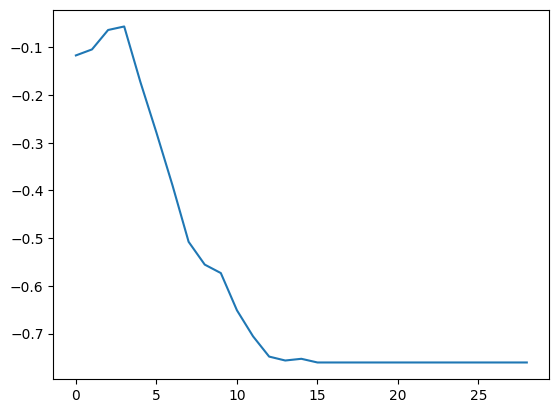

In [17]:
# test performance over different depths
r2_scores_with_depth = []

for i in range(2,31):
    tree_0_with_depth = DecisionTreeRegressor(max_depth=i, random_state=42).fit(X_train_0, y_train_0)
    y_test_pred_0_tree_with_depth = tree_0_with_depth.predict(X_test_0)
    r2_scores_with_depth.append(r2_score(y_test_0, y_test_pred_0_tree_with_depth))
    
plt.plot(r2_scores_with_depth)

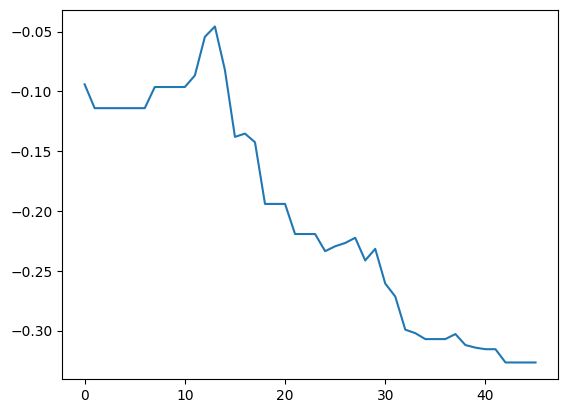

In [18]:
# controlling for max_leaf_nodes

# test performance over different max_leaf_nodes
r2_scores_with_leaf = []

for i in range(5,51):
    tree_0_with_leaf = DecisionTreeRegressor(max_leaf_nodes=i, random_state=42).fit(X_train_0, y_train_0)
    y_test_pred_0_tree_with_leaf = tree_0_with_leaf.predict(X_test_0)
    r2_scores_with_leaf.append(r2_score(y_test_0, y_test_pred_0_tree_with_leaf))
    
plt.plot(r2_scores_with_leaf)

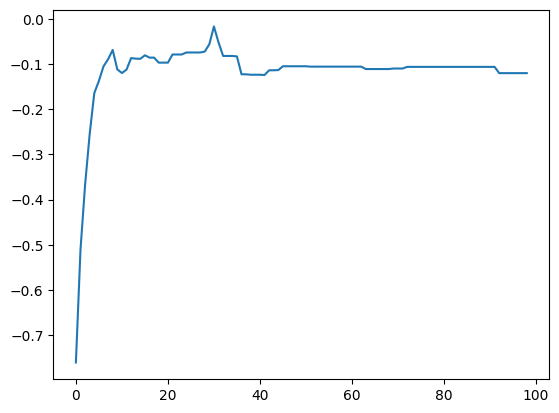

In [19]:
# controlling for min_samples_leaf

# test performance over different min_samples_leaf
r2_scores_with_min_leaf = []

for i in range(1,100):
    tree_0_with_min_leaf = DecisionTreeRegressor(min_samples_leaf=i, random_state=42).fit(X_train_0, y_train_0)
    y_test_pred_0_tree_with_min_leaf = tree_0_with_min_leaf.predict(X_test_0)
    r2_scores_with_min_leaf.append(r2_score(y_test_0, y_test_pred_0_tree_with_min_leaf))
    
plt.plot(r2_scores_with_min_leaf)

The performance on the test data doesn't seem to considerably improve with either of the 3 hyperparameters meant for pre-pruning. Hence, the overfitting problem still prevails with simple decision trees for this dataset.

### Ensembles of Decision Trees
#### Random Forest
This learner can help with the overfitting tendency of decision trees a little bit.

In [21]:
# training the model
from sklearn.ensemble import RandomForestRegressor
forest_0 = RandomForestRegressor(random_state=2) 
forest_0.fit(X_train_0, y_train_0)

# training performance
y_train_pred_rf_0 = forest_0.predict(X_train_0)
print(mean_squared_error(y_train_0, y_train_pred_rf_0),r2_score(y_train_0, y_train_pred_rf_0))

0.44485031055900615 0.8595813988321754


In [22]:
# performance on the test set
y_test_pred_rf_0 = forest_0.predict(X_test_0)
print(mean_squared_error(y_test_0, y_test_pred_rf_0),r2_score(y_test_0, y_test_pred_rf_0))

5.939824761904761 -0.37431740651937795


In [53]:
print(X_test_0[:1]) # first value in test set
print(X_test_0.sort_values(by=["day","hour"]).head()) # test set after sorting
print(y_test_0[:1]) # actual target value for 1st element in test set
print(y_test_pred_rf_0[0]) # predicted value for the random forest learner

    year  month  day  hour
27  2024      4   10    10
     year  month  day  hour
102  2024      4    1     8
91   2024      4    1    10
84   2024      4    1    12
85   2024      4    1    14
86   2024      4    1    16
27    2
Name: #_rentals, dtype: int64
1.83


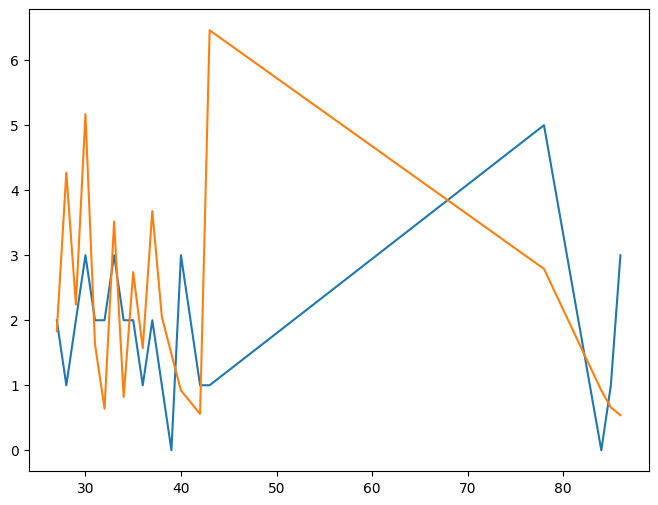

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(y_test_0[:20].index, y_test_0[:20])
plt.plot(y_test_0[:20].index, y_test_pred_rf_0[:20])
plt.show()

Something does not appear right here. Maybe reducing the forecasting time should increase the performance.